In [7]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import datetime
import sys
from tqdm import tqdm
import os
import random
import pickle
from glob import glob
import gc
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings('ignore')


In [8]:
config = f"""
execution:
    exp_id: exp_015
    debug: False
    submit: False
    multiprocessing: True

dataset: 
    competition_dir: /kaggle/input/child-mind-institute-detect-sleep-states
    cv_split_path: /kaggle/input/cv_split/train_folds.csv
    train_base_path: /kaggle/input/train_base/train_base.csv
    step_csv_dir: /kaggle/input/save_series_csv/csvs

feature:
    agg_freq: 24 # [step]

xgboost:    
    objective: "binary:logistic"
    learning_rate: 0.1  # 0.01で固定。学習時間とのトレードオフ
    reg_alpha: 0.02  # L1正則化。0.1が推奨。
    reg_lambda: 0.2  # L2正則化。0.1が推奨
    random_state: 42
    max_depth: 5  # 3-8。7くらいでいい。
    colsample_bytree: 0.7  # カラムが多い時は少なめ(0.4とか)にする。
    
seed: 46
"""

CFG = yaml.load(config, Loader=yaml.SafeLoader)

CFG["output_dir"] = f"/kaggle/output/{CFG['execution']['exp_id']}"
os.makedirs(CFG["output_dir"], exist_ok=True)

In [9]:
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
labels.head()

,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


100%|██████████| 269/269 [00:34<00:00,  7.81it/s]


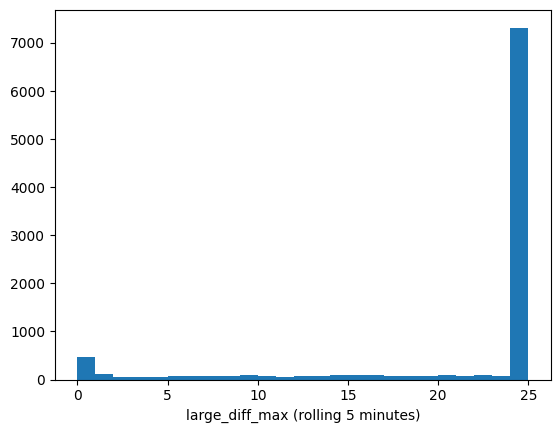

100%|██████████| 269/269 [00:34<00:00,  7.76it/s]


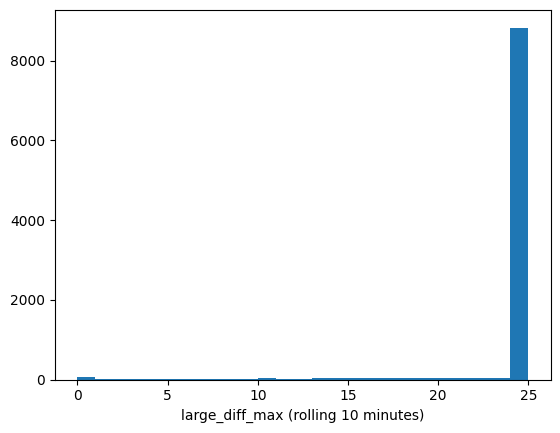

100%|██████████| 269/269 [00:34<00:00,  7.73it/s]


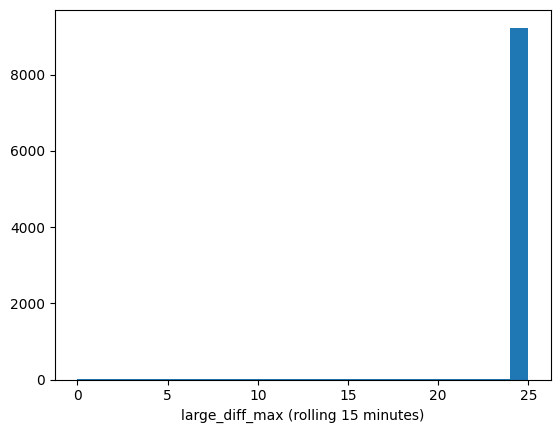

100%|██████████| 269/269 [00:34<00:00,  7.71it/s]


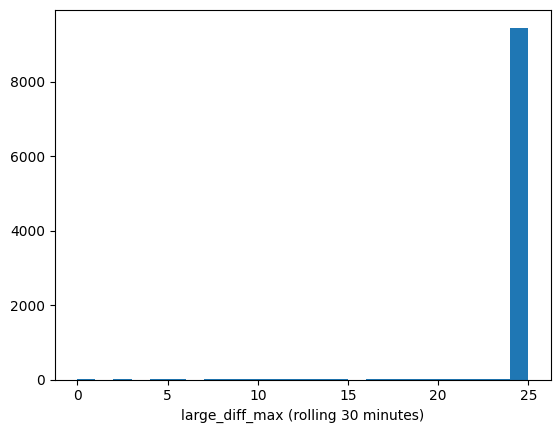

In [80]:
for m in [5, 10, 15, 30]:
    xs = []
    MAX = 25
    for series_id, label_df in tqdm(labels.groupby("series_id")):
        df = pd.read_parquet(f"{CFG['dataset']['step_csv_dir']}/{series_id}.parquet")

        df["anglez_diffabs"] = df["anglez"].diff().abs().fillna(0)
        df["large_diff_max"] = df["anglez_diffabs"].rolling(12*m, center=True).max().fillna(100)
        df = df.dropna(subset=["event"])
        df.loc[df["large_diff_max"] > MAX, "large_diff_max"] = MAX
        xs += df["large_diff_max"].tolist()

    plt.hist(xs, bins=range(MAX+1))
    plt.xlabel(f"large_diff_max (rolling {m} minutes)")
    plt.show()